# `-------------------Health Care Stroke Classifier-------------------`

## `Attribute Information`

* 1) id: unique identifier
* 2) gender: "Male", "Female" or "Other"
* 3) age: age of the patient
* 4) hypertension: "NO" if the patient doesn't have hypertension, "Yes" if the patient has hypertension
* 5) heart_disease: "NO" if the patient doesn't have any heart diseases, "Yes" if the patient has a heart disease
* 6) ever_married: "No" or "Yes"
* 7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
* 8) Residence_type: "Rural" or "Urban"
* 9) avg_glucose_level: average glucose level in blood
* 10) bmi: body mass index
* 11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
* 12) stroke: "Yes" if the patient had a stroke or "NO" if not

## `Objectives` 
* 1- Data Preprocessing (encoding & scaling , oversampling , undersampling , featureselection)
* 2- Build Machine Learning Models to predict if person prone to stroke or not
* 3- Model Selection and Tuning 

### Import Some Helper Library

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline 
sns.set_theme(context = 'paper' , style = 'whitegrid' , palette = 'Dark2' , font_scale=1.1 
              , rc = {'figure.figsize' : (10 , 4)})

In [3]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder , StandardScaler , RobustScaler , MinMaxScaler , PolynomialFeatures
from sklearn.pipeline import Pipeline , make_pipeline
from datasist.structdata import detect_outliers
from sklearn.impute import SimpleImputer , KNNImputer
from category_encoders import BinaryEncoder
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import GaussianNB , MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , VotingClassifier , BaggingClassifier ,GradientBoostingClassifier,AdaBoostClassifier
from xgboost import XGBClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score , recall_score , precision_score , f1_score , plot_confusion_matrix , plot_roc_curve,fbeta_score
from sklearn.model_selection import cross_validate , train_test_split , GridSearchCV , StratifiedKFold , RandomizedSearchCV
from sklearn.feature_selection import SequentialFeatureSelector , SelectFromModel
from sklearn.compose import ColumnTransformer
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import make_pipeline , pipeline
import joblib
from imblearn.under_sampling import RandomUnderSampler

### Read Data Set

In [4]:
df = pd.read_csv('Modified-healthcare-dataset-stroke-data.csv')

### Data OverView 

In [5]:
df.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.00,NO,YES,Yes,Private,Urban,228.69,36.60,formerly smoked,YES
1,Female,61.00,NO,NO,Yes,Self-employed,Rural,202.21,30.50,never smoked,YES
2,Male,80.00,NO,YES,Yes,Private,Rural,105.92,32.50,never smoked,YES


In [6]:
df.tail(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5107,Female,35.00,NO,NO,Yes,Self-employed,Rural,82.99,30.60,never smoked,NO
5108,Male,51.00,NO,NO,Yes,Private,Rural,166.29,25.60,formerly smoked,NO
5109,Female,44.00,NO,NO,Yes,Govt_job,Urban,85.28,26.20,Unknown,NO


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   object 
 3   heart_disease      5110 non-null   object 
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   object 
dtypes: float64(3), object(8)
memory usage: 439.3+ KB


## In Data preprocessing we will use 4 ways with outlier points 
* 1- outlier points is true data and cant delete it 
* 2- delete outlier points from data
* 3- convert outlier points into nan and impute it 
* 4- convert this columns into categories (binned)

In [8]:
x , y = df.drop(['stroke'] , axis = 1 ) , df['stroke'].apply(lambda x : 1 if x == 'YES' else 0)
x1 , y1 = df.drop(['stroke'] , axis = 1 ) , df['stroke'].apply(lambda x : 1 if x == 'YES' else 0)
x2 , y2 = df.drop(['stroke'] , axis = 1 ) , df['stroke'].apply(lambda x : 1 if x == 'YES' else 0)
x3 , y3 = df.drop(['stroke'] , axis = 1 ) , df['stroke'].apply(lambda x : 1 if x == 'YES' else 0)

In [9]:
y.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

<AxesSubplot:xlabel='stroke', ylabel='count'>

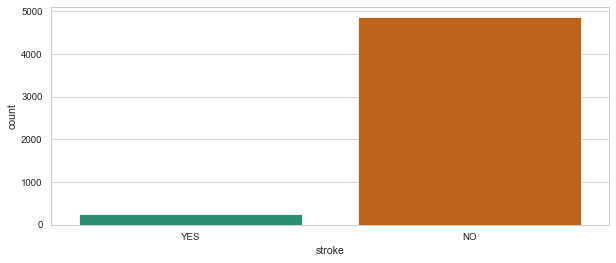

In [10]:
sns.countplot(df['stroke'])

## For encoding we need to know for each categorical column how many categories it has

In [11]:
for col in df.select_dtypes('object_'):
    display(f'{col} with {df[col].nunique()} category.'.title())

'Gender With 2 Category.'

'Hypertension With 2 Category.'

'Heart_Disease With 2 Category.'

'Ever_Married With 2 Category.'

'Work_Type With 4 Category.'

'Residence_Type With 2 Category.'

'Smoking_Status With 4 Category.'

'Stroke With 2 Category.'

In [12]:
col_to_encode = ['gender' , 'hypertension' , 'heart_disease' , 'ever_married' , 'smoking_status' ,
                 'Residence_type' , 'work_type']

In [13]:
models = []
models.append(('LR' , LogisticRegression()))
models.append(('KNNC' , KNeighborsClassifier()))
models.append(('NB' , MultinomialNB()))
models.append(('SVC' , SVC()))
models.append(('DTC' , DecisionTreeClassifier()))
models.append(('RFC' , RandomForestClassifier()))
models.append(('XGB' , XGBClassifier()))
models.append(('Voting' , VotingClassifier(estimators=[('DTC' , DecisionTreeClassifier()) , 
                                                      ('RF' , RandomForestClassifier()) , 
                                                      ('XG' , XGBClassifier())])))
models.append(('ANN' , MLPClassifier()))

In [14]:
scoring = ['accuracy' , 'recall' , 'f1' , 'precision']

In [15]:
trans = ColumnTransformer(transformers=[('ohe',OneHotEncoder(sparse=False , drop = 'first'),col_to_encode)],
                          remainder='passthrough')
trans

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 OneHotEncoder(drop='first', sparse=False),
                                 ['gender', 'hypertension', 'heart_disease',
                                  'ever_married', 'smoking_status',
                                  'Residence_type', 'work_type'])])

In [16]:
smt = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
sm = SMOTE(sampling_strategy={1 : 1500})
rm = RandomUnderSampler(sampling_strategy={0 : 2000})

In [17]:
def ModelScores(X , Y):
    for model in models :
        PL = make_pipeline(trans, smt , StandardScaler() if model[0] != 'NB' else MinMaxScaler(), model[1])
        scores = cross_validate(estimator=PL , X = X , y = Y , cv = 5 , scoring=scoring  , return_train_score=True )
        print('-'*60)
        print(model[0])
        print(f'train accuracy : {scores["train_accuracy"].mean()} , test accuracy : {scores["test_accuracy"].mean()}'.title())
        print(f'train recall : {scores["train_recall"].mean()} , test recall : {scores["test_recall"].mean()}'.title())
        print(f'train precision : {scores["train_precision"].mean()} , test precision : {scores["test_precision"].mean()}'.title())
        print(f'train f1_score : {scores["train_f1"].mean()} , test f1_score : {scores["test_f1"].mean()}'.title())

## 1- `Impute outliers bmi & avg_glucose_level by KNN Imputer`

In [18]:
x1['bmi'].loc[detect_outliers(x1 , 0 , ['bmi'])] = np.nan

In [19]:
x1['avg_glucose_level'].loc[detect_outliers(x1 , 0 , ['avg_glucose_level'])] = np.nan

In [20]:
imputer = KNNImputer(n_neighbors=3)

In [21]:
x1[x1.select_dtypes('number').columns] = imputer.fit_transform(x1[x1.select_dtypes('number').columns])

In [22]:
ModelScores(x1 , y1)

------------------------------------------------------------
LR
Train Accuracy : 0.7425636007827788 , Test Accuracy : 0.7432485322896282
Train Recall : 0.822291457286432 , Test Recall : 0.7953469387755101
Train Precision : 0.138735285738745 , Test Precision : 0.13644240861981732
Train F1_Score : 0.237408135536122 , Test F1_Score : 0.23280340634679905
------------------------------------------------------------
KNNC
Train Accuracy : 0.927641878669276 , Test Accuracy : 0.8549902152641877
Train Recall : 0.9748844221105528 , Test Recall : 0.2569795918367347
Train Precision : 0.40056077713289584 , Test Precision : 0.10229489189834577
Train F1_Score : 0.5677652221793772 , Test F1_Score : 0.14566074316824892
------------------------------------------------------------
NB
Train Accuracy : 0.6586105675146772 , Test Accuracy : 0.6536203522504891
Train Recall : 0.6897437185929649 , Test Recall : 0.6584489795918367
Train Precision : 0.09343559066781905 , Test Precision : 0.08879255705294077
Train 

## 2- `bin bmi & avg_glucose_level into categories to solve outlier problem`

In [23]:
bmi_bins , bmi_labels = [0, 19, 25,30,100] , ['Underweight', 'Ideal', 'Overweight', 'Obesity']
joblib.dump(bmi_bins , 'bmi_bins.h5')
joblib.dump(bmi_labels , 'bmi_labels.h5')

['bmi_labels.h5']

In [24]:
x2['bmi_cat'] = pd.cut(x2['bmi'], bins = bmi_bins, labels = bmi_labels)

In [25]:
bmi_mapper = {'Underweight' : 0 , 'Ideal' : 1 , 'Overweight' : 2 , 'Obesity' : 3}
joblib.dump(bmi_mapper , 'bmi_mapper.h5')

['bmi_mapper.h5']

In [26]:
x2['bmi_cat'] = x2['bmi_cat'].map(bmi_mapper).astype(int)

In [27]:
glucose_bins , glucose_labels = [0,90,160,230,500] , ['Low', 'Normal', 'High', 'Very High']
joblib.dump(glucose_bins , 'glucose_bins.h5')
joblib.dump(glucose_labels , 'glucose_labels.h5')

['glucose_labels.h5']

In [28]:
x2['glucose_cat'] = pd.cut(x2['avg_glucose_level'], bins = glucose_bins, labels = glucose_labels)

In [29]:
glucose_mapper = {'Low' : 0 , 'Normal' : 1 , 'High' : 2 , 'Very High' : 3}
joblib.dump(glucose_mapper , 'glucose_mapper.h5')

['glucose_mapper.h5']

In [30]:
x2['glucose_cat'] = x2['glucose_cat'].map(glucose_mapper).astype(int)

In [31]:
x2.drop(['avg_glucose_level' , 'bmi'] , axis = 1 , inplace = True )

In [1039]:
ModelScores(x2 , y2)

------------------------------------------------------------
LR
Train Accuracy : 0.7382583170254404 , Test Accuracy : 0.7391389432485324
Train Recall : 0.8253065326633167 , Test Recall : 0.8271836734693878
Train Precision : 0.13706928107171953 , Test Precision : 0.1384754602995855
Train F1_Score : 0.23508503421003293 , Test F1_Score : 0.23703290336797708
------------------------------------------------------------
KNNC
Train Accuracy : 0.9226027397260275 , Test Accuracy : 0.8526418786692759
Train Recall : 0.930713567839196 , Test Recall : 0.31697959183673474
Train Precision : 0.37996300000494304 , Test Precision : 0.11988668194550547
Train F1_Score : 0.539602210601911 , Test F1_Score : 0.17348628799381194
------------------------------------------------------------
NB
Train Accuracy : 0.6435420743639921 , Test Accuracy : 0.6403131115459882
Train Recall : 0.7138592964824121 , Test Recall : 0.6864489795918368
Train Precision : 0.09222953864836611 , Test Precision : 0.08848316949096552
Tr

# 3- `outliers is True value Run Models with it` 

In [1041]:
ModelScores(x , y)

------------------------------------------------------------
LR
Train Accuracy : 0.7453033268101761 , Test Accuracy : 0.7434442270058709
Train Recall : 0.820286432160804 , Test Recall : 0.7991836734693877
Train Precision : 0.13980870046036714 , Test Precision : 0.1370617171341809
Train F1_Score : 0.23889671602542584 , Test F1_Score : 0.23383189000444826
------------------------------------------------------------
KNNC
Train Accuracy : 0.9227984344422702 , Test Accuracy : 0.8524461839530332
Train Recall : 0.9718994974874372 , Test Recall : 0.30114285714285716
Train Precision : 0.3845047796894662 , Test Precision : 0.11645299474765207
Train F1_Score : 0.5509928136902401 , Test F1_Score : 0.16742955614407543
------------------------------------------------------------
NB
Train Accuracy : 0.6545009784735811 , Test Accuracy : 0.6493150684931507
Train Recall : 0.7007989949748743 , Test Recall : 0.6703673469387754
Train Precision : 0.09361617251895658 , Test Precision : 0.08884051694186261
Tr

# 4- `Drop outliers Points ` 

In [32]:
x3['stroke'] = y3

In [33]:
len(detect_outliers(x3 , 0 , ['avg_glucose_level' , 'bmi']))

712

In [34]:
x3.drop(detect_outliers(x3 , 0 , ['avg_glucose_level' , 'bmi']) , axis = 0 , inplace = True )

In [35]:
x3.reset_index(inplace = True , drop = True )

In [36]:
y3 = x3['stroke']
x3.drop(['stroke'] , axis = 1 , inplace = True )

In [1047]:
ModelScores(x3 , y3)

------------------------------------------------------------
LR
Train Accuracy : 0.7474421240594185 , Test Accuracy : 0.7464797290309236
Train Recall : 0.8060606060606059 , Test Recall : 0.7878787878787878
Train Precision : 0.10978488687675311 , Test Precision : 0.10770549385069532
Train F1_Score : 0.1932457067814436 , Test F1_Score : 0.18940173243665778
------------------------------------------------------------
KNNC
Train Accuracy : 0.9413368765126405 , Test Accuracy : 0.8817698314200022
Train Recall : 0.9893939393939395 , Test Recall : 0.22424242424242427
Train Precision : 0.3892546936410037 , Test Precision : 0.08544090283072114
Train F1_Score : 0.5586699359343121 , Test F1_Score : 0.12310062799581241
------------------------------------------------------------
NB
Train Accuracy : 0.662289437942746 , Test Accuracy : 0.6543885096700797
Train Recall : 0.693939393939394 , Test Recall : 0.6424242424242425
Train Precision : 0.07393061880074733 , Test Precision : 0.0676716078084844
Trai

# `-----------------Logistic Regression For Tunning-----------------`

In [605]:
LR = make_pipeline(trans ,
                   sm,rm,
                   PolynomialFeatures(),
                   MinMaxScaler(),
                   LogisticRegression(class_weight='balanced'))

In [606]:
LR_params = [
    {  
        'logisticregression__C' : [1 , 5 , 0.01],
        'polynomialfeatures__degree' : [1 , 2]
    }
]

In [607]:
LR_grid = GridSearchCV(estimator=LR , cv = StratifiedKFold(n_splits=5) , param_grid = LR_params ,
                       scoring ='recall' , return_train_score=True )

In [608]:
LR_grid.fit(x2 , y2)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         ['gender',
                                                                          'hypertension',
                                                                          'heart_disease',
                                                                          'ever_married',
                                                                          'smoking_status',
                                                                          'Residence_type',
                                                                          'work_type'])])),
                                       ('randomundersam...
                                        RandomUnderSampler(sampling_strategy={0: 2000})),
                                       ('smote',
                                        SMOTE(sampling_strategy={1: 1500})),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid=[{'logisticregression__C': [1, 5, 0.01],
                          'polynomialfeatures__degree': [1, 2]}],
             return_train_score=True, scoring='recall')

In [609]:
LR_grid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married',
                                                   'smoking_status',
                                                   'Residence_type',
                                                   'work_type'])])),
                ('randomundersampler',
                 RandomUnderSampler(sampling_strategy={0: 2000})),
                ('smote', SMOTE(sampling_strategy={1: 1500})),
                ('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=5, class_weight='balanced'))])

In [610]:
LR_grid.best_score_

0.8111020408163265

In [611]:
LR_grid.cv_results_['mean_train_score'].max()

0.8293115577889448

In [612]:
LR_grid.cv_results_['mean_test_score'].max()

0.8111020408163265

In [613]:
LR_Model = LR_grid.best_estimator_

In [614]:
accuracy_score(LR_Model.predict(x2) , y2)

0.7250489236790607

In [615]:
fbeta_score(LR_Model.predict(x2) , y2 , beta=0.5)

0.4179566563467492

In [616]:
precision_score(LR_Model.predict(x2) , y2)

0.8674698795180723

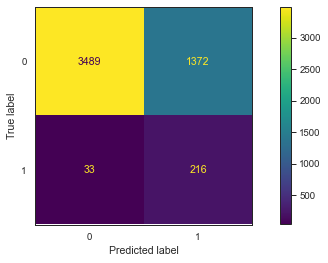

In [617]:
sns.set_style('white')
plot_confusion_matrix(LR_Model , x2 , y2)

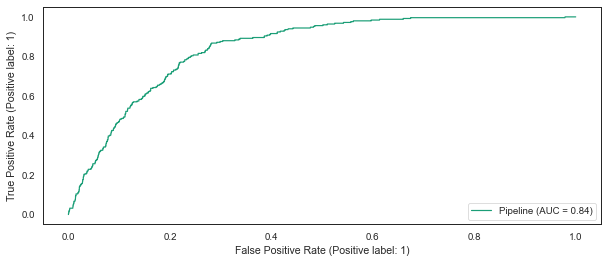

In [618]:
plot_roc_curve(LR_Model , x2 , y2)

In [983]:
joblib.dump(LR_Model , 'LRC.h5')

['LRC.h5']

# `-----------------Support Vector Machine For Tunning-----------------`

In [666]:
SVM = make_pipeline(trans , smt, MinMaxScaler() , SVC() )

In [667]:
SVC_params = [
    {  
        'svc__kernel' : ['linear'],'svc__C':[1 , 5 , 0.1]
    },
    {
        'svc__kernel' : ['poly'],'svc__degree' : [1 , 2],'svc__C':[1 , 5 , 0.01]
    },
    {
        'svc__kernel' : ['rbf'],'svc__gamma':[1 , 5,0.1]
    },
    {
        'svc__kernel' : ['sigmoid'] , 'svc__gamma':[1 , 5,0.1]
    }
]

In [668]:
SVC_grid = GridSearchCV(estimator=SVM , cv = StratifiedKFold(n_splits=5) , param_grid = SVC_params ,
                        scoring ='recall' , return_train_score=True )

In [669]:
SVC_grid.fit(x2 , y2)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         ['gender',
                                                                          'hypertension',
                                                                          'heart_disease',
                                                                          'ever_married',
                                                                          'smoking_status',
                                                                          'Residence_type',
                                                                          'work_type'])])),
                                       ('smotetomek',
                                        SM...kLinks(sampling_strategy='majority'))),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('svc', SVC())]),
             param_grid=[{'svc__C': [1, 5, 0.1], 'svc__kernel': ['linear']},
                         {'svc__C': [1, 5, 0.01], 'svc__degree': [1, 2],
                          'svc__kernel': ['poly']},
                         {'svc__gamma': [1, 5, 0.1], 'svc__kernel': ['rbf']},
                         {'svc__gamma': [1, 5, 0.1],
                          'svc__kernel': ['sigmoid']}],
             return_train_score=True, scoring='recall')

In [670]:
SVC_grid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married',
                                                   'smoking_status',
                                                   'Residence_type',
                                                   'work_type'])])),
                ('smotetomek',
                 SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                ('minmaxscaler', MinMaxScaler()),
                ('svc', SVC(C=0.01, degree=1, kernel='poly'))])

In [671]:
SVC_grid.best_score_

0.8954285714285714

In [673]:
SVC_grid.cv_results_['mean_train_score'].max()

0.9026231155778893

In [674]:
SVC_grid.cv_results_['mean_test_score'].max()

0.8954285714285714

In [675]:
SVC_Model = SVC_grid.best_estimator_

In [676]:
accuracy_score(SVC_Model.predict(x2) , y2)

0.6365949119373777

In [677]:
precision_score(SVC_Model.predict(x2) , y2)

0.891566265060241

In [678]:
fbeta_score(SVC_Model.predict(x2) , y2 , beta=0.5)

0.36417322834645677

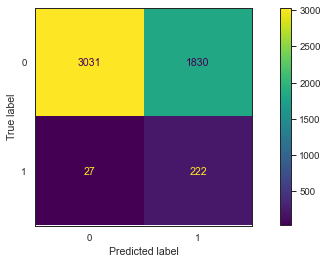

In [679]:
plot_confusion_matrix(SVC_Model , x2 , y2)

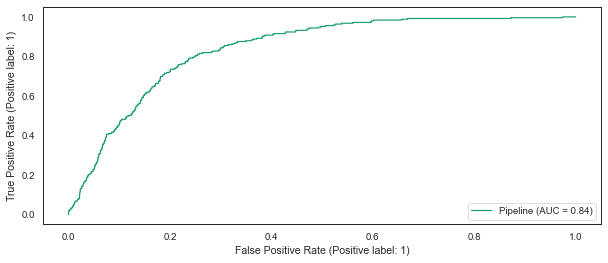

In [680]:
plot_roc_curve(SVC_Model , x2 , y2)

In [984]:
joblib.dump(SVC_Model , 'SVC.h5')

['SVC.h5']

# `-----------------DecisionTreeClassifier For Tunning-----------------`

In [959]:
DT_params = [
    {
        'decisiontreeclassifier__criterion' : ['gini','entropy'],
        'decisiontreeclassifier__splitter' : ['best' , 'random'],
        'decisiontreeclassifier__max_depth' : [4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
        'decisiontreeclassifier__min_samples_leaf' : [1,2,3,4,5,6,7,8,9,10],
        'decisiontreeclassifier__min_weight_fraction_leaf' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
        'decisiontreeclassifier__min_samples_split': [2, 5, 10],
        'decisiontreeclassifier__max_features' : ['auto','log2','sqrt',None],
        'decisiontreeclassifier__max_leaf_nodes' : [None,10,20,30,40,50,60,70,80,90] 
    }
]

In [968]:
DTC = make_pipeline(trans ,rm,sm ,SelectFromModel(estimator=DecisionTreeClassifier()),
                    MinMaxScaler(), DecisionTreeClassifier())
DTC.steps

[('columntransformer',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('ohe',
                                   OneHotEncoder(drop='first', sparse=False),
                                   ['gender', 'hypertension', 'heart_disease',
                                    'ever_married', 'smoking_status',
                                    'Residence_type', 'work_type'])])),
 ('randomundersampler', RandomUnderSampler(sampling_strategy={0: 2000})),
 ('smote', SMOTE(sampling_strategy={1: 1500})),
 ('selectfrommodel', SelectFromModel(estimator=DecisionTreeClassifier())),
 ('minmaxscaler', MinMaxScaler()),
 ('decisiontreeclassifier', DecisionTreeClassifier())]

In [976]:
DTC_RanGrid = RandomizedSearchCV(estimator=DTC , param_distributions=DT_params ,
                                 scoring='recall' , cv = StratifiedKFold(n_splits=5) ,
                                 return_train_score=True , n_iter=20)

In [977]:
DTC_RanGrid.fit(x2 , y2)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse=False),
                                                                               ['gender',
                                                                                'hypertension',
                                                                                'heart_disease',
                                                                                'ever_married',
                                                                                'smoking_status',
                                                                                'Residence_type',
                                                                                'work_type'])])),
                                             ('randomun...
                                         'decisiontreeclassifier__max_leaf_nodes': [None,
                                                                                    10,
                                                                                    20,
                                                                                    30,
                                                                                    40,
                                                                                    50,
                                                                                    60,
                                                                                    70,
                                                                                    80,
                                                                                    90],
                                         'decisiontreeclassifier__min_samples_leaf': [1,
                                                                                      2,
                                                                                      3,
                                                                                      4,
                                                                                      5,
                                                                                      6,
                                                                                      7,
                                                                                      8,
                                                                                      9,
                                                                                      10],
                                         'decisiontreeclassifier__min_samples_split': [2,
                                                                                       5,
                                                                                       10],
                                         'decisiontreeclassifier__min_weight_fraction_leaf': [0.1,
                                                                                              0.2,
                                                                                              0.3,
                                                                                              0.4,
                                                                                              0.5,
                                                                                              0.6,
                                                                                     

In [978]:
DTC_RanGrid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married',
                                                   'smoking_status',
                                                   'Residence_type',
                                                   'work_type'])])),
                ('randomundersampler',
                 RandomUnderSampler(sampling_strategy={0: 2000})),
                ('smote', SMOTE(sampling_strategy={1: 1500})),
                ('selectfrommodel',
                 SelectFromModel(estimator=DecisionTreeClassifier())),
                ('minmaxscaler', MinMaxScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=15,
                                        max_leaf_nodes=50, min_samples_leaf=7,
                                        min_weight_fraction_leaf=0.4))])

In [985]:
DTC_RanGrid.best_params_

{'decisiontreeclassifier__splitter': 'best',
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.4,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_samples_leaf': 7,
 'decisiontreeclassifier__max_leaf_nodes': 50,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_depth': 15,
 'decisiontreeclassifier__criterion': 'entropy'}

In [979]:
DTC_RanGrid.best_score_

0.8672653061224491

In [986]:
DTC_RanGrid.cv_results_['mean_train_score']

array([0.26560302,        nan, 0.63634673, 0.        , 0.50396985,
       0.33632663, 0.17788945, 0.86649749, 0.        ,        nan,
              nan,        nan, 0.        , 0.        , 0.41378894,
       0.        , 0.31778894,        nan, 0.19396985, 0.        ])

In [980]:
accuracy_score(DTC_RanGrid.best_estimator_.predict(x2) , y2)

0.6714285714285714

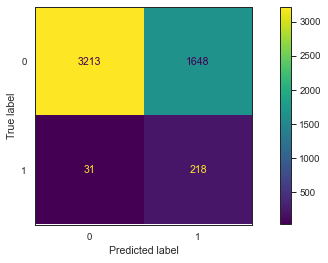

In [981]:
plot_confusion_matrix(DTC_RanGrid.best_estimator_ , x2 , y2)

In [987]:
joblib.dump(DTC_RanGrid.best_estimator_ , 'DTC.h5')

['DTC.h5']

# `-----------------RandomForestClassifier For Tunning-----------------`

In [841]:
RF_params = [
    {
        'randomforestclassifier__bootstrap': [True, False],
        'randomforestclassifier__criterion':['gini','entropy'],
        'randomforestclassifier__max_depth': [4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
        'randomforestclassifier__max_features': ['auto','log2','sqrt',None],
        'randomforestclassifier__min_weight_fraction_leaf':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
        'randomforestclassifier__min_samples_leaf':[1,2,3,4,5,6,7,8,9,10],
        'randomforestclassifier__min_samples_split': [2, 5, 10],
        'randomforestclassifier__n_estimators': list(range(30, 500, 20)),
        'randomforestclassifier__max_leaf_nodes':[None,10,20,30,40,50,60,70,80,90]
    }
]

In [853]:
RFC = make_pipeline(trans , smt , SelectFromModel(estimator=RandomForestClassifier())
                    ,MinMaxScaler() , RandomForestClassifier())

In [854]:
RFC.steps

[('columntransformer',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('ohe',
                                   OneHotEncoder(drop='first', sparse=False),
                                   ['gender', 'hypertension', 'heart_disease',
                                    'ever_married', 'smoking_status',
                                    'Residence_type', 'work_type'])])),
 ('smotetomek', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
 ('selectfrommodel', SelectFromModel(estimator=RandomForestClassifier())),
 ('minmaxscaler', MinMaxScaler()),
 ('randomforestclassifier', RandomForestClassifier())]

In [855]:
RF_RanGrid = RandomizedSearchCV(estimator=RFC , param_distributions=RF_params ,
                                 scoring='recall' , cv = StratifiedKFold(n_splits=5) ,
                                 return_train_score=True)

In [856]:
RF_RanGrid.fit(x2 , y2)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse=False),
                                                                               ['gender',
                                                                                'hypertension',
                                                                                'heart_disease',
                                                                                'ever_married',
                                                                                'smoking_status',
                                                                                'Residence_type',
                                                                                'work_type'])])),
                                             ('smotetom...
                                         'randomforestclassifier__min_samples_leaf': [1,
                                                                                      2,
                                                                                      3,
                                                                                      4,
                                                                                      5,
                                                                                      6,
                                                                                      7,
                                                                                      8,
                                                                                      9,
                                                                                      10],
                                         'randomforestclassifier__min_samples_split': [2,
                                                                                       5,
                                                                                       10],
                                         'randomforestclassifier__min_weight_fraction_leaf': [0.1,
                                                                                              0.2,
                                                                                              0.3,
                                                                                              0.4,
                                                                                              0.5,
                                                                                              0.6,
                                                                                              0.7,
                                                                                              0.8,
                                                                                              0.9],
                                         'randomforestclassifier__n_estimators': [30,
                                                                                  50,
                                                                                  70,
                                                                                  90,
                                                                                  110,
                                                                                  130,
                                                                                  150,
                                                                 

In [857]:
RF_RanGrid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married',
                                                   'smoking_status',
                                                   'Residence_type',
                                                   'work_type'])])),
                ('smotetomek',
                 SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                ('selectfrommodel',
                 SelectFromModel(estimator=RandomForestClassifier())),
                ('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=12,
                                        max_features='log2', max_leaf_nodes=30,
                                        min_samples_leaf=5, min_samples_split=5,
                                        min_weight_fraction_leaf=0.5,
                                        n_estimators=370))])

In [858]:
RF_RanGrid.best_score_

0.9

In [863]:
RF_RanGrid.best_params_

{'randomforestclassifier__n_estimators': 370,
 'randomforestclassifier__min_weight_fraction_leaf': 0.5,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__max_leaf_nodes': 30,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__max_depth': 12,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__bootstrap': True}

In [859]:
RF_RanGrid.cv_results_['mean_train_score']

array([       nan, 0.90452261,        nan, 0.83330653, 0.82228141,
       0.83132161, 0.83132161, 0.73020101, 0.81022613,        nan])

In [860]:
accuracy_score(RF_RanGrid.best_estimator_.predict(x2) , y2)

0.7403131115459882

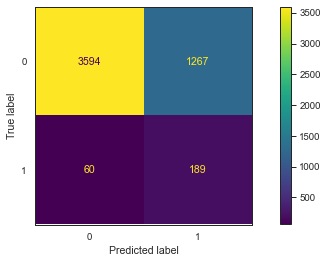

In [861]:
plot_confusion_matrix(RF_RanGrid.best_estimator_ , x2 , y2)

In [917]:
joblib.dump(RF_RanGrid.best_estimator_ , 'RFC.h5')

['RFC.h5']

# `Let's Have Fun :) `

In [1089]:
LZC = LazyClassifier(custom_metric=recall_score)

In [1090]:
x_train , x_test , y_train , y_test = train_test_split(x2 , y2 , test_size=0.2 , random_state=7 , stratify=y)

In [1091]:
Models , prediction = LZC.fit(x_train , x_test , y_train , y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:06<00:00,  4.21it/s]


In [1092]:
Models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,recall_score,Time Taken
Model,,,,,,
NearestCentroid,0.67,0.77,0.77,0.76,0.88,0.04
GaussianNB,0.83,0.74,0.74,0.87,0.64,0.05
BernoulliNB,0.87,0.65,0.65,0.90,0.40,0.05
DecisionTreeClassifier,0.92,0.61,0.61,0.92,0.26,0.06
LabelSpreading,0.93,0.58,0.58,0.93,0.18,1.24
LabelPropagation,0.93,0.57,0.57,0.93,0.18,0.69
ExtraTreeClassifier,0.93,0.55,0.55,0.92,0.14,0.04
BaggingClassifier,0.94,0.54,0.54,0.93,0.10,0.13
ExtraTreesClassifier,0.93,0.54,0.54,0.92,0.10,0.44


In [4]:
from sklearn.neighbors import NearestCentroid

In [1107]:
NC = make_pipeline(trans, smt , StandardScaler(), NearestCentroid())

In [1108]:
NC

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married',
                                                   'smoking_status',
                                                   'Residence_type',
                                                   'work_type'])])),
                ('smotetomek',
                 SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                ('standardscaler', StandardScaler()),
                ('nearestcentroid', NearestCentroid())])

In [1109]:
scores = cross_validate(estimator=PL , X = x2 , y = y2 , cv = StratifiedKFold(n_splits=5) , 
                        scoring=scoring  , return_train_score=True )

In [1111]:
print(f'train accuracy : {scores["train_accuracy"].mean()} , test accuracy : {scores["test_accuracy"].mean()}'.title())
print(f'train recall : {scores["train_recall"].mean()} , test recall : {scores["test_recall"].mean()}'.title())
print(f'train precision : {scores["train_precision"].mean()} , test precision : {scores["test_precision"].mean()}'.title())
print(f'train f1_score : {scores["train_f1"].mean()} , test f1_score : {scores["test_f1"].mean()}'.title())

Train Accuracy : 0.6597358121330725 , Test Accuracy : 0.6567514677103719
Train Recall : 0.8513919597989948 , Test Recall : 0.8471020408163266
Train Precision : 0.11080461113129259 , Test Precision : 0.10944821659837115
Train F1_Score : 0.19607873194791703 , Test F1_Score : 0.19382675781983194
